**Import libraries**

In [2]:
import keras
from keras.applications import ResNet50
from keras import layers, Model, Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


**Dataset paths and Loading**

In [3]:
# path to the dataset (i'm working on google colab and I uploaded the dataset in myDrive)

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
path = "/content/drive/MyDrive/brain_tumor/"

Mounted at /content/drive/


In [4]:
# Paths to the train and test datasets
train_dir = "/content/drive/MyDrive/brain_tumor/Training/"
test_dir = "/content/drive/MyDrive/brain_tumor/Testing/"


# Load the training dataset from folders
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224,224),   # resize all images to 224x224 (required for ResNet50)
    batch_size=64,          # number of images per batch
    label_mode="categorical",  # one-hot encoding of labels (needed for categorical_crossentropy)
    shuffle=True            # shuffle training data for better generalization
)

# Load the test dataset (no shuffle so evaluation is reproducible)
test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224,224),
    batch_size=64,
    label_mode="categorical",
    shuffle=False
)


Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


**Data augmentation and preprocessing**

In [5]:
# Data augmentation pipeline (applied on the fly during training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # randomly flip images horizontally
    layers.RandomRotation(0.1),       # randomly rotate images by ±10%
])

# Default preprocessing function for ResNet50:
# - converts RGB to BGR
# - subtracts ImageNet mean
# - scales values to match training setup of ResNet50
normalization = layers.Lambda(keras.applications.resnet50.preprocess_input)

# Apply augmentation + normalization to the training dataset
train_dataset = train_dataset.map(
    lambda x, y: (normalization(data_augmentation(x, training=True)), y)
)

# Apply only normalization to the test dataset (no augmentation at test time)
test_dataset  = test_dataset.map(
    lambda x, y: (normalization(x), y)
)

**Labels mapping and sample visualization**

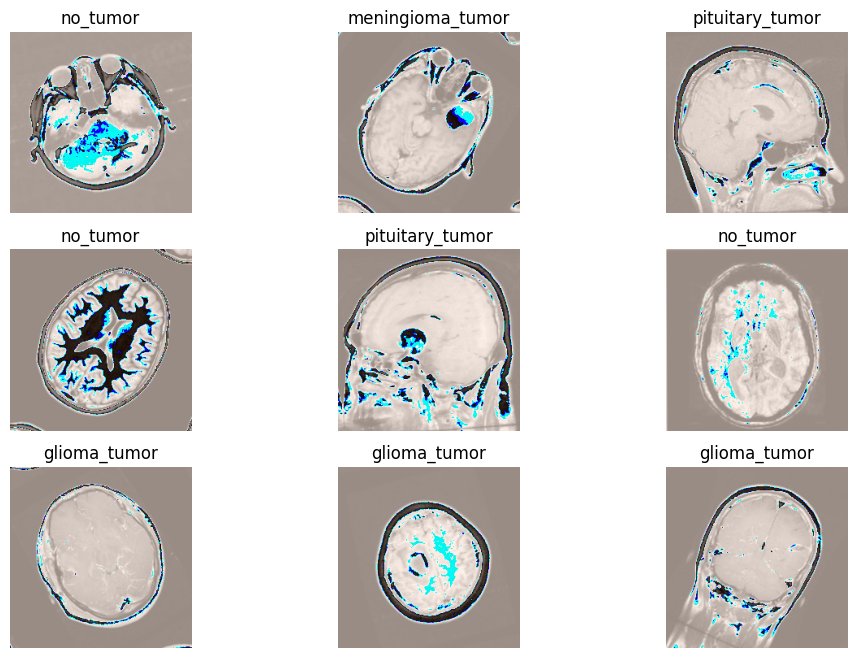

In [6]:
# Mapping class indices to their string labels
labels_map = {
    0: "glioma_tumor",
    1: "meningioma_tumor",
    2: "no_tumor",
    3: "pituitary_tumor"
}

# Take a single batch of images and labels from the training dataset
# (train_dataset is a tf.data.Dataset, so .take(1) returns one batch)
for images, labels in train_dataset.take(1):
    images_batch, labels_batch = images, labels
    break  # not strictly necessary here, but keeps only the first batch

# Plot a grid of sample images from this batch
plt.figure(figsize=(12, 8))
rows, cols = 3, 3
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i+1)

    # Converting the tensor image to a NumPy array for Matplotlib
    # .astype("uint8") ensures values are in the correct [0,255] range
    img = images_batch[i].numpy().astype("uint8")

    # Labels are one-hot encoded, so I use argmax to get class index
    label_index = labels_batch[i].numpy().argmax()

    plt.imshow(img)
    plt.title(labels_map[label_index])
    plt.axis("off")

plt.show()


In [7]:
# Listing available GPU devices for TensorFlow

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Checking which backend Keras is currently using
keras.backend.backend()

'tensorflow'

**Using the ResNet50 model**

In [9]:
from keras.applications import ResNet50
from keras import layers, Model

# Loading the pretrained ResNet50 model without the fully connected top layers
# pooling="avg" applies a GlobalAveragePooling2D on the convolutional output
model_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
    pooling="avg"
)
model_resnet.trainable = False  # freeze all convolutional layers, the backbone is used only as a feature extractor

# Add a custom classification head for the 4 classes
x = layers.Dense(256, activation='relu')(model_resnet.output)  # intermediate dense layer
x = layers.Dropout(0.5)(x)                                    # regularization to reduce overfitting
outputs = layers.Dense(4, activation='softmax')(x)            # final classification layer (4 classes)

# final model
model = Model(inputs=model_resnet.input, outputs=outputs)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Compiling and Training the model**

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),   # Adam optimizer with learning rate = 0.0001
    loss="categorical_crossentropy",         # loss for multi-class classification
    metrics=["accuracy"]
)


In [11]:
# Train the model on the training dataset, and validate on the test dataset

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 807s 9s/step - accuracy: 0.5429 - loss: 1.1531 - val_accuracy: 0.8040 - val_loss: 0.5376
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 73s 771ms/step - accuracy: 0.8331 - loss: 0.4811 - val_accuracy: 0.8421 - val_loss: 0.4324
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 787ms/step - accuracy: 0.8614 - loss: 0.3895 - val_accuracy: 0.8459 - val_loss: 0.3923
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 70s 774ms/step - accuracy: 0.8767 - loss: 0.3517 - val_accuracy: 0.8703 - val_loss: 0.3493
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 71s 783ms/step - accuracy: 0.8857 - loss: 0.3187 - val_accuracy: 0.8673 - val_loss: 0.3426
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 85s 818ms/step - accuracy: 0.8940 - loss: 0.2950 - val_accuracy: 0.8780 - val_loss: 0.3005
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 82s 814ms/step - accuracy: 0.9054 - loss: 0.2725 - val_accuracy: 0.8841 - val_loss: 0.2955
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 772ms/step - accuracy: 0.8994 - loss: 0.2716 - val_accura

Both training and validation accuracy steadily improved, reaching ~92% and ~91% respectively.
Validation loss kept decreasing, showing the model is still learning without signs of overfitting.

**Training history visualization**

In [12]:
# Extract training and validation metrics from the history

train_losses = history.history['loss']
train_accuracies = history.history['accuracy']
test_losses = history.history['val_loss']
test_accuracies = history.history['val_accuracy']


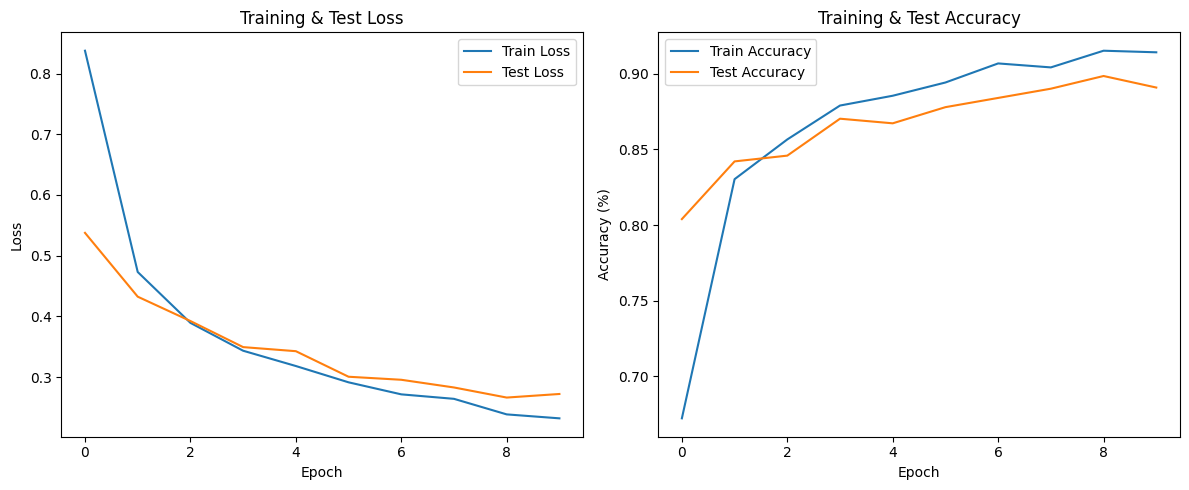

In [13]:
# plot Losses and Accuracies history

plt.figure(figsize=(12, 5))

# --- Losses ---
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Training & Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# --- Accuracies ---
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.title("Training & Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.tight_layout()
plt.show()

**Predictions visualization**

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step


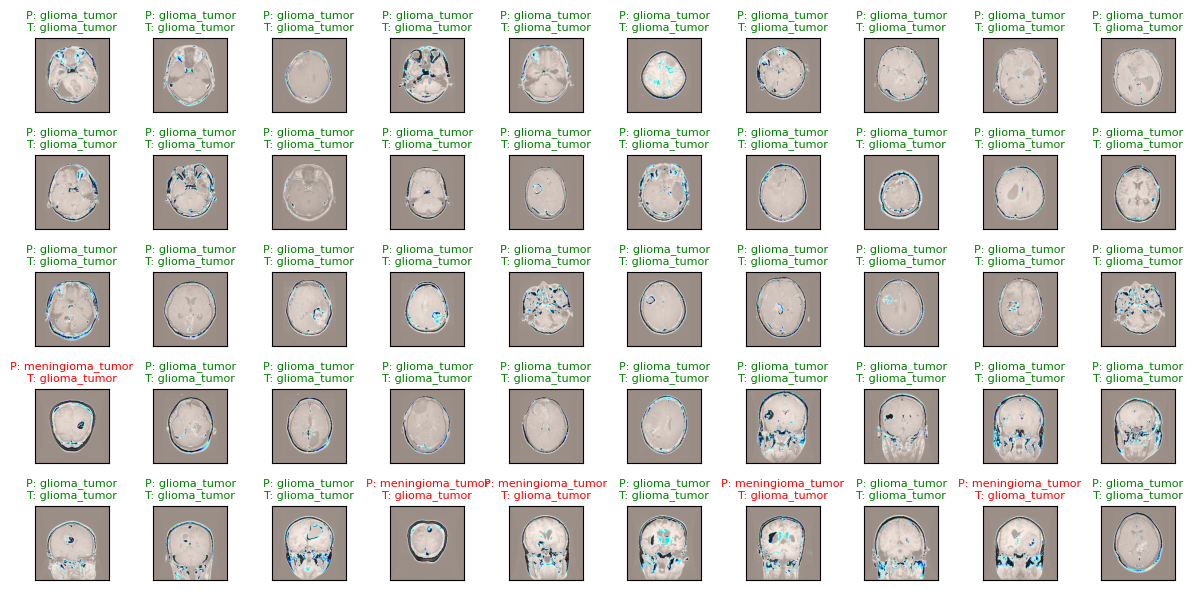

In [14]:
# Visualize predictions made by the model to see where it is correct or wrong

 # use one batch from the test dataset
for images, labels in test_dataset.take(1):
    preds = model.predict(images)         # the model's predictions (softmax probabilities)
    predicted = np.argmax(preds, axis=1)   # convert probabilities to the predicted class indices
    true_labels = np.argmax(labels, axis=1) # convert one-hot encoded labels to class indices

    fig = plt.figure(figsize=(12, 6))
    # display the first 40 images in the batch
    for i in range(50):
        ax = fig.add_subplot(5, 10, i+1, xticks=[], yticks=[])
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set title showing predicted vs true label : Green if prediction is correct, red if incorrect
        color = "green" if predicted[i] == true_labels[i] else "red"
        ax.set_title(f"P: {labels_map[predicted[i]]}\nT: {labels_map[true_labels[i]]}",
                     color=color, fontsize=8)

    plt.tight_layout()
    plt.show()
    break
